# Arrival Diagnostics After iLoc Filtering

The purpose of this notebook is to generate various diagnostic plots based on *ensemble.all.txt*, which is produced in Step 6 of the picking workflow and contains all arrivals from preexisting catalogues and automatically detected arrivals, after having passed through iLoc.

Valuable insights are also gained by comparing the travel-time residual distributions (for P- and S-arrival) and local ray-path coverage before/after iLoc filtering. Plots of distributions of identified phases (after iLoc) over local distances provide cues to the effectiveness of iLoc in filtering out undesired phases e.g. Pn and Sn phases that bottom out in the uppermost mantle.



In [1]:
import numpy as np
import glob
import matplotlib.pyplot as plt

import numpy as np
from scipy.spatial import cKDTree
#from pykrige.uk import UniversalKriging
import shapefile
import matplotlib as mpl
import matplotlib.tri as tri
from mpl_toolkits.basemap import Basemap
import os, sys 
import pandas
from collections import defaultdict
from tqdm import tqdm

sys.path.append("/g/data/ha3/fxz547/Githubz/hiperseis/") #('/g/data/ha3/rakib/seismic/pst/passive-seismic/')
# sys.path.append('/g/data/ha3/rakib/seismic/pst/passive-seismic/')

from seismic.pick_harvester.utils import CatalogCSV
from seismic.ASDFdatabase.FederatedASDFDataSet import FederatedASDFDataSet

from matplotlib import interactive
interactive(True)

%matplotlib inline

# Read Arrivals

In [2]:
# Path to output of step 7 in the picking workflow

PATH='/g/data/ha3/Passive/SHARED_DATA/Scratch/picking_workflow/step_7/'

In [3]:
arrivals = pandas.read_csv('%s/ensemble.all.txt'%PATH, delim_whitespace=True) 

In [4]:
# print columns
arrivals.columns

Index(['#eventID', 'originTimestamp', 'mag', 'originLon', 'originLat',
       'originDepthKm', 'net', 'sta', 'cha', 'pickTimestamp', 'phase',
       'stationLon', 'stationLat', 'az', 'baz', 'distance', 'ttResidual',
       'snr', 'qualityMeasureCWT', 'domFreq', 'qualityMeasureSlope',
       'bandIndex', 'nSigma'],
      dtype='object')

# Plot Travel-time Residuals


Text(0.5, 0, 'Travel-time residual [s]')

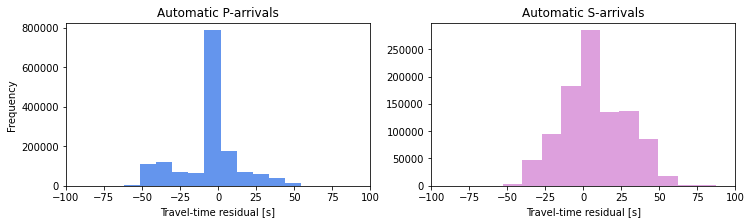

In [5]:
# plot histograms for automatically detected p and s arrivals 
# Note that automatically detected arrivals are identified by columns e.g. 'snr', 'nsigma', etc. 
# with a positive value

fig, axes = plt.subplots(1,2)
fig.set_size_inches(12,3)

auto_p = arrivals['ttResidual'][(arrivals['snr']>0) & (arrivals['phase'] == 'P')]
auto_s = arrivals['ttResidual'][(arrivals['snr']>0) & (arrivals['phase'] == 'S')]

axes[0].hist(auto_p, fc='cornflowerblue', ec='none', bins=20)
axes[0].set_xlim(-100,100)
axes[0].set_title('Automatic P-arrivals')
axes[0].set_xlabel('Travel-time residual [s]')
axes[0].set_ylabel('Frequency')

axes[1].hist(auto_s, fc='plum', ec='none', bins=20)
axes[1].set_xlim(-100,100)
axes[1].set_title('Automatic S-arrivals')
axes[1].set_xlabel('Travel-time residual [s]')


# Local Raypath (<10 deg) Coverage in the Australasian Region

In [6]:
# Generate 0.1x0.1 deg grid

from geographiclib.geodesic import Geodesic
geod = Geodesic.WGS84

# define 0.1x0.1 deg grid
au_sx, au_ex, dx = 110, 155, 0.1 # Australasian region (lon bounds)
au_sy, au_ey, dy = -45, -10, 0.1 # Australasian region (lat bounds)

nx = np.int_(np.ceil((au_ex-au_sx)/dx))+1
ny = np.int_(np.ceil((au_ey-au_sy)/dy))+1
res = int(1/float(dx)) # per deg

gx, gy = np.meshgrid(np.linspace(au_sx, au_ex, nx), np.linspace(au_sy, au_ey, ny), indexing='ij')
ge = np.zeros(gx.shape)

# Apply spatial clip and use only P+Pg and S+Sg arrivals

gzp = np.zeros(gx.shape)
gzs = np.zeros(gx.shape)

local_distance = 10 # deg

au_arrivals = arrivals[(arrivals['originLon']>au_sx) & (arrivals['originLon']<au_ex) & 
                       (arrivals['originLat']>au_sy) & (arrivals['originLat']<au_ey) &
                       (arrivals['stationLon']>au_sx) & (arrivals['stationLon']<au_ex) & 
                       (arrivals['stationLat']>au_sy) & (arrivals['stationLat']<au_ey) &
                       (arrivals['distance']<local_distance)]

au_arrivals_p = au_arrivals[(au_arrivals['phase']=='P') | (au_arrivals['phase']=='Pg')]
au_arrivals_s = au_arrivals[(au_arrivals['phase']=='S') | (au_arrivals['phase']=='Sg')]

print ('#P-arrivals: %d, #S-arrivals: %d'%(len(au_arrivals_p), len(au_arrivals_s)))

#P-arrivals: 20948, #S-arrivals: 1531


In [7]:
# Generate surface-projected local (<=10 deg) ray-path coverage for P- and S-arrivals
# on a 0.1x0.1 deg grid within the Australasian region.

geod = Geodesic.WGS84

peset = set()
psset = set()

for i in tqdm(np.arange(len(au_arrivals_p))):
    elon, elat, slon, slat = au_arrivals_p['originLon'].iloc[i], au_arrivals_p['originLat'].iloc[i], \
                             au_arrivals_p['stationLon'].iloc[i], au_arrivals_p['stationLat'].iloc[i]
    
    peset.add((elon, elat))
    psset.add((slon, slat))
    
    g = geod.Inverse(elat, elon, slat, slon)
    l = geod.Line(g['lat1'], g['lon1'], g['azi1'])
    num = int(np.ceil(g['a12']*res))

    for j in range(num+1):
        pos = l.ArcPosition(j * g['a12'] / num)
        cy, cx = pos['lat2'], pos['lon2']
    
        cxi = np.int_((cx - au_sx)/dx)
        cyi = np.int_((cy - au_sy)/dy)
        
        gzp[cxi, cyi] += 1        
    # end for
# end for    

print ('P-arrivals: Unique #events (%d), Unique #stations (%d)'%(len(peset), len(psset)))

seset = set()
ssset = set()
for i in tqdm(np.arange(len(au_arrivals_s))):
    elon, elat, slon, slat = au_arrivals_s['originLon'].iloc[i], au_arrivals_s['originLat'].iloc[i], \
                             au_arrivals_s['stationLon'].iloc[i], au_arrivals_s['stationLat'].iloc[i]
    
    seset.add((elon, elat))
    ssset.add((slon, slat))
    
    g = geod.Inverse(elat, elon, slat, slon)
    l = geod.Line(g['lat1'], g['lon1'], g['azi1'])
    num = int(np.ceil(g['a12']*res))

    for j in range(num+1):
        pos = l.ArcPosition(j * g['a12'] / num)
        cy, cx = pos['lat2'], pos['lon2']
    
        cxi = np.int_((cx - au_sx)/dx)
        cyi = np.int_((cy - au_sy)/dy)
        
        gzs[cxi, cyi] += 1        
    # end for
# end for   

print ('S-arrivals: Unique #events (%d), Unique #stations (%d)'%(len(seset), len(ssset)))

 10%|▉         | 149/1531 [00:00<00:00, 1488.95it/s]

P-arrivals: Unique #events (2460), Unique #stations (495)


100%|██████████| 1531/1531 [00:01<00:00, 1498.75it/s]

S-arrivals: Unique #events (1079), Unique #stations (167)


/g/data/ha3/Passive/Software/VENV/para_h5py/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/g/data/ha3/Passive/Software/VENV/para_h5py/lib/python3.7/site-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


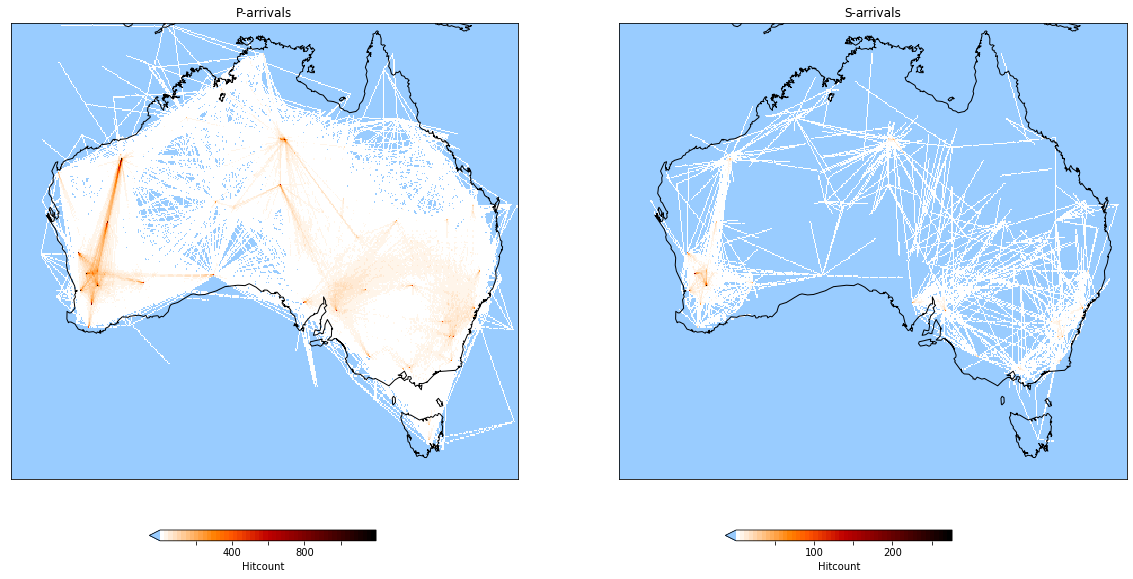

In [8]:
# (hiperseispy37) fxz547@vdi-n19 /g/data/ha3/fxz547/Githubz/hiperseis/seismic/pick_harvester/notebooks (develop)
# $ jupyter-notebook &> jupyter.log &
# Plot coverage

import matplotlib.tri as tri
from matplotlib import colors

# Plot p-coverage
fig,ax=plt.subplots(1,2)

fig.set_size_inches(20,10)
cax1 = fig.add_axes([0.1,0.1,0.4,0.1])
cax2 = fig.add_axes([0.5,0.1,0.4,0.1])
cax1.set_visible(False)
cax2.set_visible(False)

m = Basemap(ax=ax[0],projection='merc', lat_ts=-27, llcrnrlat=-45,urcrnrlat=-10,\
            llcrnrlon=110,urcrnrlon=155, resolution='l')
m.drawcoastlines()

pgx, pgy = m(gx, gy)

cbi=m.pcolormesh(pgx, pgy, gzp, vmin=1, vmax=np.max(gzp), cmap=plt.get_cmap('gist_heat_r', 50))

cbi.cmap.set_under('#99ccff')
cbar = fig.colorbar(cbi, ax=cax1, format='%d', extend='min', 
                    norm=colors.Normalize(clip=False), 
                    orientation='horizontal')
cbar.set_label("Hitcount")
ax[0].set_title('P-arrivals')
for label in cbar.ax.get_xticklabels()[::2]:
    label.set_visible(False)

# Plot s-coverage
m = Basemap(ax=ax[1],projection='merc', lat_ts=-27, llcrnrlat=-45,urcrnrlat=-10,\
            llcrnrlon=110,urcrnrlon=155, resolution='l')
m.drawcoastlines()

pgx, pgy = m(gx, gy)

cbi=m.pcolormesh(pgx, pgy, gzs, vmin=1, vmax=np.max(gzs), cmap=plt.get_cmap('gist_heat_r', 50))

cbi.cmap.set_under('#99ccff')
cbar = fig.colorbar(cbi, ax=cax2, format='%d', extend='min', 
                    norm=colors.Normalize(clip=False), 
                    orientation='horizontal')
cbar.set_label("Hitcount")
ax[1].set_title('S-arrivals')
for label in cbar.ax.get_xticklabels()[::2]:
    label.set_visible(False)
    

# Plot Distributions of Local (<10 deg) Phases

Unique phases: ['Sn', 'Sg', 'Pb', 'Lg', 'Sb', 'P', 'Pn', 'Pg']


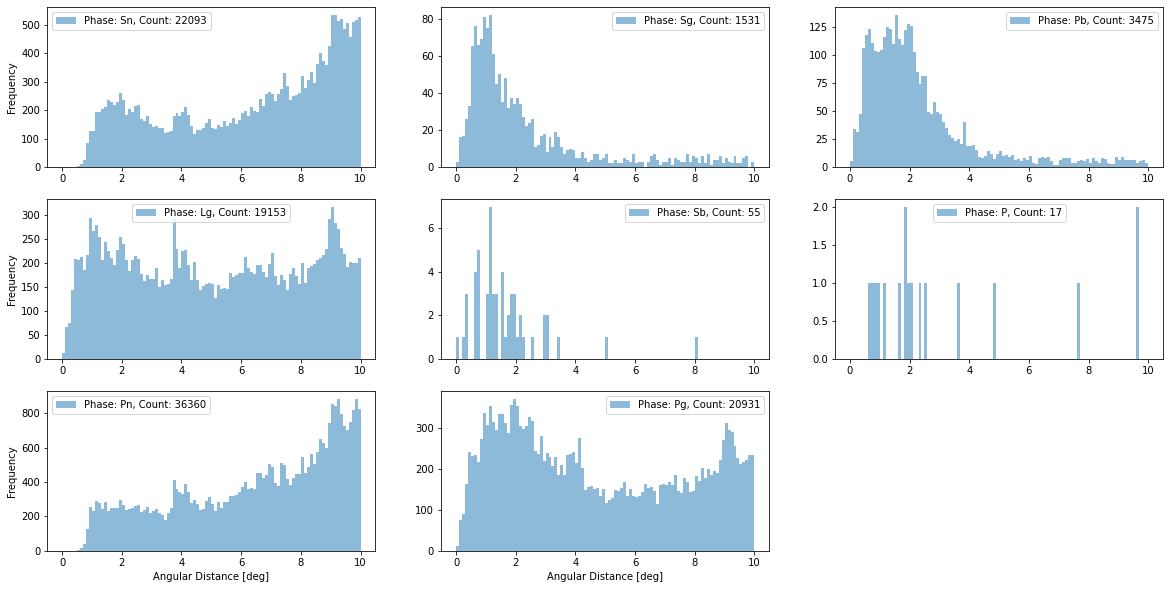

In [9]:
fig, axes = plt.subplots(3,3)
fig.set_size_inches(20,10)
s = set(au_arrivals['phase'])
print ('Unique phases:', list(s))

for ax in axes.flatten(): ax.set_visible(False)

bins = np.linspace(0,10,101)
for i,si in enumerate(s):
    m,n = np.divmod(i,3)
    ax = axes[m,n]
    vals = au_arrivals['distance'][au_arrivals['phase']==si]    
    ax.set_visible(True)
    _ = ax.hist(vals, bins=bins, 
                alpha=0.5, edgecolor='none', label='Phase: %s, Count: %d'%(si, len(vals)))
    ax.legend(loc='best')    
    
    if(n==0): ax.set_ylabel('Frequency')
    if(m==2): ax.set_xlabel('Angular Distance [deg]')